## Project Description

Zillow is a tech real estate online marketplace with multiple listings and price estimation for properties around the United States. The intention behind this porject is to create a predictive model to aid in assessing home value. The data used for this project is the historical data from 2017 for Single Family housing.

## Project Goals

- To discover drivers of housing prices from the feature set
- To create a Regression model that will be able to predict the housing price of Single Family Homes
- The feature set used to predict house prices is aquired from Zillow
- The end goal of the model is to achieve predictions within 5% of actual price
- Deliver a report of the findings to Zillow team


In [1]:
import functions2 as f
import wrangle as w
import new_lib as nl
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from scipy import stats

## Wrangle
- Data acquired from Zillow Database
- Organized into feature set that will be used 
- Data is from the 2017 Single Family homes that were involved in transactions

In [2]:
zil = w.wrangle_zillow()
zil, fences = nl.remove_outliers(zil)
train, validate, test, X_train, y_train, X_val, y_val, X_test, y_test = nl.train_vailidate_test_split(zil, 'tax_value')
train_scaled, val_scaled, test_scaled = nl.scale_splits(X_train, X_val, X_test, MinMaxScaler(), ['bedrooms', 'bathrooms', 'square_footage', 'lot_size', 'yearbuilt'])
train_scaled = pd.get_dummies(train_scaled, columns= ['fips'])
# Calling and organizing data

fips column ignored


In [3]:
cont_var = ['bedrooms','bathrooms','square_footage','lot_size','yearbuilt']
cat_var = zil.fips
target = zil.tax_value
# Establishing variable types for report

## Explore

- Attempting to discern drivers behind home cost
- Visualize the different features
- Test the features to see which are most relevant

In [4]:
f.select_kbest(train_scaled, y_train, f_regression, 3)

,bathrooms,square_footage,yearbuilt
index,,,
18573,0.285714,0.320749,0.550459
32318,0.285714,0.274198,0.513761
17200,0.285714,0.411581,0.486239
570,0.000000,0.241272,0.311927
32875,0.428571,0.507806,0.495413


Using the kbest function I found that bathrooms, square footage, and yearbuilt were the three best drivers

In [5]:
f.rfe_ranks(3, train_scaled, y_train)

,ranking,feature
0,1,fips_6037.0
1,1,fips_6059.0
2,1,fips_6111.0
3,2,square_footage
4,3,bedrooms
5,4,bathrooms
6,5,lot_size
7,6,yearbuilt
8,7,id


However, when I used an rfe I found that each fips code was the most important indicator and putting that aside square footage and bedrooms were still at the top of the list

I also ran a correlation test which found that square footage, and bathrooms were the two best drivers

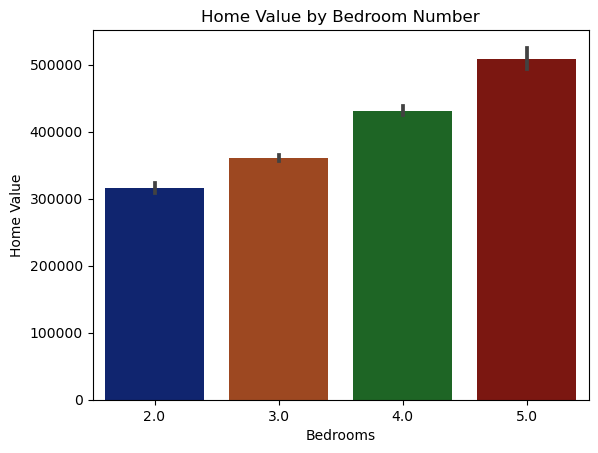

In [6]:
f.bed_plot(train)

### Bedroom count is clearly a good driver for home price and the bar chart clearly displays a positive relationship with the number of bedrooms and the price of a home

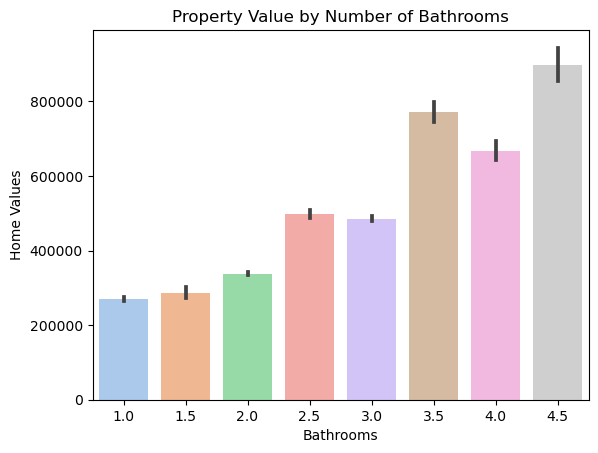

In [7]:
f.bath_plot(train)

### Bathrooms was slightly worse as a driver than bedrooms and there is an interesting dip between 3.5 and 4 bathrooms but outside of that and 2.5 to 3 it is a strong positive relationship

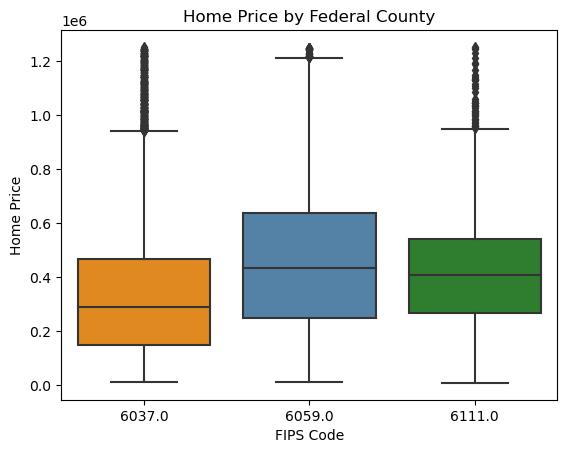

In [8]:
f.county_plot(train)

### FIPS Code 6059 has a greater average price than the other two counties. After research the counties were identified as L.A, Orange County, and Ventura County respectivley

This is visual evidence that county location is a strong driver of home price

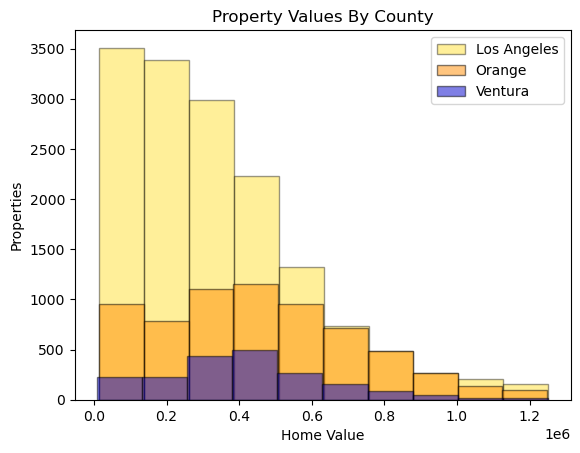

In [9]:
f.hist_plot(train)

### Here is a better visualization of the counties home prices overlayed on each other.
### Of note is that while L.A has the greatest amount of properties the average value of the properties tends to be lower than the other two

## Exploration Summary

- Bedrooms and bathrooms are both good drivers of house price however bedrooms is the better indicator
- Total lot size actual had a rather small correlation with price perhaps because some cheaper L.A plots had a large lot
- FIPS or Federal County Code had a significant impact on housing price which does fall in line with my original hypothesis
- Statistically the best driver appeared to be square footage

## Modeling
- I used three diferent models during this phase (OLS, Polynomial Regression, and LassoLars)
- Polynomial Regression had the best results and was the only model moved forward to the test stage
- It resulted in a raw 36,000 dollar average increase in accuracy for the predictions

In [55]:
f.room_cnt(train_scaled)
# Combining bedroom and bathroom features into one room count feature

,id,square_footage,lot_size,yearbuilt,fips_6037.0,fips_6059.0,fips_6111.0,room_count
index,,,,,,,,
18573,2138356,0.320749,0.429523,0.550459,1,0,0,0.619048
32318,2695053,0.274198,0.406632,0.513761,0,1,0,0.619048
17200,145241,0.411581,0.574161,0.486239,0,1,0,0.619048
570,643458,0.241272,0.370100,0.311927,1,0,0,0.000000
32875,1144215,0.507806,0.516384,0.495413,0,1,0,1.095238
...,...,...,...,...,...,...,...,...
11025,1131359,0.471757,0.328238,0.697248,0,1,0,1.095238
31513,523097,0.487369,0.600267,0.577982,0,0,1,1.238095
18178,526213,0.267386,0.320477,0.376147,1,0,0,0.333333


### OLS Linear Model

In [56]:
linear = f.linear_regression(train_scaled, y_train)
linear

,actual,baseline,lm_preds
index,,,
18573,269997.0,380044.138663,316385.112743
32318,68248.0,380044.138663,347607.988756
17200,271093.0,380044.138663,434226.144700
570,39307.0,380044.138663,298645.603895
32875,492428.0,380044.138663,478668.876688
...,...,...,...
11025,701000.0,380044.138663,453199.819605
31513,710674.0,380044.138663,453825.540205
18178,923877.0,380044.138663,267758.898972


In [57]:
f.assess(linear['actual'], linear['lm_preds'])
# Model Assesment

222757.74

### LassoLars Model

In [58]:
lasso = f.lasso_lars(train_scaled, y_train)
lasso

,actual,baseline,lasso_preds
index,,,
18573,269997.0,380044.138663,316428.732321
32318,68248.0,380044.138663,347614.599185
17200,271093.0,380044.138663,434172.485029
570,39307.0,380044.138663,298612.238828
32875,492428.0,380044.138663,478633.203310
...,...,...,...
11025,701000.0,380044.138663,453198.677862
31513,710674.0,380044.138663,453781.728305
18178,923877.0,380044.138663,267778.519644


In [59]:
f.assess(lasso['actual'], lasso['lasso_preds'])

222757.74

### Polynomial Model

In [60]:
poly = f.polynomial(train_scaled, y_train)
poly

,actual,baseline,poly_preds
index,,,
18573,269997.0,380044.138663,289090.444835
32318,68248.0,380044.138663,325343.754899
17200,271093.0,380044.138663,395913.697747
570,39307.0,380044.138663,299729.782332
32875,492428.0,380044.138663,407813.688150
...,...,...,...
11025,701000.0,380044.138663,480198.075280
31513,710674.0,380044.138663,415888.075418
18178,923877.0,380044.138663,276415.466799


In [61]:
f.assess(poly['actual'], poly['poly_preds'])

217476.2

In [62]:
f.assess(lasso['actual'], lasso['baseline'])

256725.26

#### Moving on to the test set with the best model

In [63]:
f.room_cnt(test_scaled)

,id,square_footage,lot_size,yearbuilt,fips,room_count
index,,,,,,
29516,1389329,0.220551,0.465428,0.715596,6037.0,0.952381
5322,1280539,0.423503,0.208921,0.678899,6059.0,0.571429
38993,270223,0.343741,0.634603,0.311927,6037.0,0.619048
11465,226181,0.217144,0.401145,0.394495,6037.0,0.333333
21105,1145379,0.389441,0.577219,0.605505,6059.0,0.952381
...,...,...,...,...,...,...
50569,645125,0.231621,0.428426,0.357798,6037.0,0.333333
12821,209307,0.395685,0.406632,0.577982,6111.0,1.285714
31130,1308028,0.451888,0.677877,0.412844,6059.0,0.952381


In [64]:
test = f.polynomial(test_scaled, y_test)
test

,actual,baseline,poly_preds
index,,,
29516,341016.0,377473.606942,233163.209069
5322,395083.0,377473.606942,559887.758587
38993,722000.0,377473.606942,343748.573629
11465,171326.0,377473.606942,232829.447233
21105,296484.0,377473.606942,359292.936445
...,...,...,...
50569,713063.0,377473.606942,241060.514492
12821,292300.0,377473.606942,365331.914059
31130,521000.0,377473.606942,399777.140343


In [65]:
f.assess(test['actual'], test['poly_preds'])

220414.45

In [66]:
round(f.assess(test['actual'], test['baseline']) - f.assess(test['actual'], test['poly_preds']), 2)

35490.18

## Model Summary
- Polynomial was the best model but all models were relatively close to each other
- The room count feature did not alter the result significantly
- $35,000 raw improvement

## Takeaways and Conclusion
- The model can be improved upon but the inital improvment is still signficant
- My hypothesis were generally correct and the identified feature set did give accurate drivers of home price
- Zillow ought to consider location to be among its most important factors in home price